## Background
The New York Times has published data for case counts and deaths for each county and state across the US. They also have a few additional datasets, one of which is a July 2020 survey of how regularly people in each county wore masks. This data comes for an online survey of about 250,000 responses.

You've been tasked with looking at the relationship between reported mask usage and case counts per capita (at the county level) for the state of Utah. This analysis is with real data so expect some level of cleaning and manipulation.

Data and descriptions are available at their GitHub page (https://github.com/nytimes/covid-19-data) but for consistency I've uploaded the relevant ones to the Canvas page under "Datasets".

Relevant Datasets:
* `county_census.csv`: Population estimates in 2019 by county
* `mask-use-by-county.csv`: Reported mask usage taken from the NY Time July 2020 survey
* `us-counties.csv`: Case and death county by county


### Task 1
First, you'll need to read in the three datasets and `merge` them together. The `SimpleLinearRegression.ipynb` file may be a useful reference.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from math import sqrt

import os
import sys
from pathlib import Path

cur_dir = Path(os.getcwd()).parent
original_path = os.getcwd()

downloads_path = str(Path.home() / "Downloads")
os.chdir(downloads_path)

df1 = pd.read_csv('us-counties.csv', index_col=False)

df1 = df1[df1['state'] == 'Utah']
df1.reset_index(drop=True, inplace=True)
df1 = df1[df1['fips'].notna()]
df1['fips'] = df1['fips'].astype(int)
df1['deaths'] = df1['deaths'].astype(int)

df2 = pd.read_csv('mask-use-by-county.csv', index_col=False)

# print(df2['COUNTYFP'].duplicated().any())
df2.rename(columns={
    'COUNTYFP': 'fips'
}, inplace=True)

df3 = pd.read_csv('county_census.csv', index_col=False)

df3 = df3[['POPESTIMATE2019', 'FIPS']]

df3.rename(columns={
    'POPESTIMATE2019': 'population',
    'FIPS': 'fips'
}, inplace=True)

# dataframes = [df1, df2, df3]
# for dfs in dataframes:
#     print(dfs.head(10).to_string())

county_info_df = pd.merge(df1,
                          df3,
                          on='fips',
                          how='left')

county_info_df = county_info_df[['county', 'state', 'fips', 'cases', 'deaths', 'population']]
# print(county_info_df.to_string())

county_mask_df = pd.merge(county_info_df,
                          df2,
                          on='fips',
                          how='left')
print(county_mask_df.to_string())

        county state   fips   cases  deaths  population  NEVER  RARELY  SOMETIMES  FREQUENTLY  ALWAYS
0       Beaver  Utah  49001    1609      16        6710  0.099   0.026      0.271       0.283   0.320
1    Box Elder  Utah  49003   14100     124       56046  0.084   0.116      0.111       0.270   0.419
2        Cache  Utah  49005   37192     109      128289  0.090   0.108      0.080       0.310   0.411
3       Carbon  Utah  49007    5234      46       20463  0.107   0.134      0.114       0.293   0.353
4      Daggett  Utah  49009     151       0         950  0.091   0.296      0.102       0.330   0.181
5        Davis  Utah  49011  100743     403      355481  0.035   0.055      0.077       0.314   0.518
6     Duchesne  Utah  49013    4371      27       19938  0.051   0.259      0.033       0.469   0.188
7        Emery  Utah  49015    2472      28       10012  0.122   0.109      0.106       0.239   0.424
8     Garfield  Utah  49017     929      16        5051  0.062   0.056      0.232 

### Task 2
Since we're only interested in Utah, create a new data frame that contains only the merged data for the state of Utah. If you need to do some Googling, I'd suggest searching "conditional subset pandas dataframe".

In [15]:
### Accidently did that in Task 1

### Task 3
The case count data is just an absolute cumulative count, meaning that larger counties unsurprisingly have much larger case counts. This may skew our results since we're just interested in the relative relationship between reported mask usage and cases. Create a new variable that is a ratio of `cases/population`. Note: the name of the population variable is `POPESTIMATE2019`.

In [16]:
county_mask_df['cases_per_capita'] = county_mask_df['cases'] / county_mask_df['population']
print(county_mask_df.to_string())

        county state   fips   cases  deaths  population  NEVER  RARELY  SOMETIMES  FREQUENTLY  ALWAYS  cases_per_capita
0       Beaver  Utah  49001    1609      16        6710  0.099   0.026      0.271       0.283   0.320          0.239791
1    Box Elder  Utah  49003   14100     124       56046  0.084   0.116      0.111       0.270   0.419          0.251579
2        Cache  Utah  49005   37192     109      128289  0.090   0.108      0.080       0.310   0.411          0.289908
3       Carbon  Utah  49007    5234      46       20463  0.107   0.134      0.114       0.293   0.353          0.255779
4      Daggett  Utah  49009     151       0         950  0.091   0.296      0.102       0.330   0.181          0.158947
5        Davis  Utah  49011  100743     403      355481  0.035   0.055      0.077       0.314   0.518          0.283399
6     Duchesne  Utah  49013    4371      27       19938  0.051   0.259      0.033       0.469   0.188          0.219230
7        Emery  Utah  49015    2472     

### Task 4
Finally, run a regression where our **predictor variable** is the proportion of people that responed "Always" to the question of "*How often do you wear a mask in public when you expect to be within six feet of another person?*" and the **response variable** is your newly created `cases_per_capita` variable.

                            OLS Regression Results                            
Dep. Variable:       cases_per_capita   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     10.72
Date:                Wed, 17 May 2023   Prob (F-statistic):            0.00290
Time:                        12:27:59   Log-Likelihood:                 51.958
No. Observations:                  29   AIC:                            -99.92
Df Residuals:                      27   BIC:                            -97.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1642      0.026      6.300      0.0

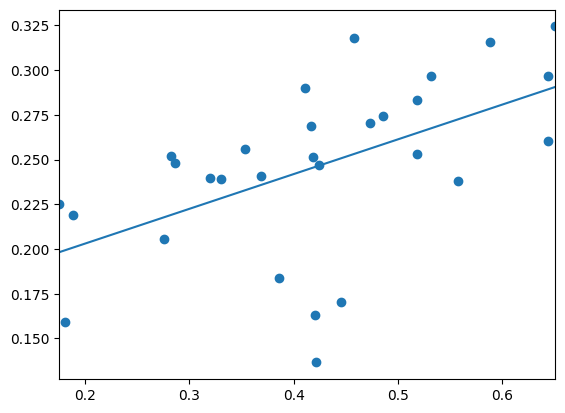

In [17]:
results = smf.ols('cases_per_capita ~ ALWAYS', data=county_mask_df).fit()
print(results.summary())

fig = sm.graphics.abline_plot(model_results=results)
ax = fig.axes[0]
ax.scatter(county_mask_df['ALWAYS'], county_mask_df['cases_per_capita'])
plt.show()

In [20]:
xbar = np.mean(county_mask_df['ALWAYS'])
ybar = np.mean(county_mask_df['cases_per_capita'])
numerator = np.sum((county_mask_df['ALWAYS'] - xbar)*(county_mask_df['cases_per_capita'] - ybar))
denominator = np.sum((county_mask_df['ALWAYS'] - xbar)**2)

beta_1 = numerator/denominator
print('Beta_1  ' + str(beta_1))
beta_0 = ybar - beta_1*xbar
print('Beta_0  ' + str(beta_0))

Beta_1  0.19412930955212193
Beta_0  0.16423127146438316


### Questions

1. Are the coefficient estimate significant? What evidence is there to support your answer?

2. What proportion of variance in the response is explained by this model?

3. How would you interpret the estimates of the coefficient?

4. Does your model make sense intuitively? What could explain this result?



In [ ]:

# 1. Are the coefficient estimates significant? What evidence is there to support your answer?
#    - Yes, the coefficient estimates are significant. The p-values associated with the coefficients for the "Intercept" is less than 0.001, and the p-value for the "ALWAYS" variable is 0.003. Since both p-values are below the conventional significance level of 0.05, we have evidence to reject the null hypothesis.
#
# 2. What proportion of variance in the response is explained by this model?
#    - The R-squared value is provided as 0.284. Approximately 28.4% of the variance in the response variable (cases_per_capita) is explained by the predictor variable (ALWAYS).
#
# 3. How would you interpret the estimates of the coefficient?
#    - The "Intercept" coefficient estimate of 0.1642 represents the expected value of the response variable (cases_per_capita) when all the independent variables are set to zero. In this case, it suggests that even with no value of the "ALWAYS" variable, there would still be a positive baseline effect of 0.1642 on the cases_per_capita.
#    - The "ALWAYS" coefficient estimate of 0.1941 indicates the expected change in the cases_per_capita for each unit increase in the "ALWAYS" variable, while holding other variables constant. Therefore, for each additional unit increase in the "ALWAYS" variable, we expect an average increase of 0.1941 in the cases_per_capita.
#
# 4. Does your model make sense intuitively? What could explain this result?
#    - Based on the information provided, the "ALWAYS" variable seems to have a positive effect on the cases_per_capita. This suggests that there is a relationship between the always wearing a mask and the incidence of cases per capita. Since we know that the Always variable is suggestive of that percentage of the population wearing a mask we see that they attribute to increase in covid 19 rates. To better understand this we should run a multivariable regression to see how the other survey categories apply to the covid 19 rates for each county.
